In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from run_evolution import folder_evol
from analytical_results import fT00, fT01, fT11, fj0, fj1, fnu, fLn
from ploting import plot_heatmaps

In [2]:
NUM_COLORS = 14
cm = plt.get_cmap('nipy_spectral') #hsv') #'gist_rainbow')
colors = [cm(i / (NUM_COLORS-0.5)) for i in range(NUM_COLORS)]
lines = [':', '--', '-']

In [3]:
g = 1
v, Q = 1, 1
tol, method = 1e-6, '12site'
D0, D = 256, 256
#
ms = [0, 0.1, 0.2, 0.318309886, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mg = [g * x for x in ms]

NaDdt =  [ (1024, 1/16, 512, 1/16)]  # (512, 0.0625, 256, 1/16),  (512, 1/8, 1024, 1/16),

data = {}

for m in ms:
    for N, a, D, dt in NaDdt:
        D0 = D
        try:
            folder = folder_evol(g, m, a, N, v, Q, D0, dt, D, tol, method, mkdir=False)
            data[m, N, a, D, dt] = np.load(folder / f"results.npy", allow_pickle=True).item()
        except FileNotFoundError:
            pass

In [4]:
def get_tsm(signals, ev):
    tm = signals["time"]
    mask = tm > -1
    tm = tm[mask]
    ee = signals[ev][mask]
    ee = ee - ee[0, :]
    ee =  (ee[:, 0::2] + ee[:, 1::2]) / 2  # average over 2*n and 2*n+1
    mid = (ee[:, N//4] + ee[:, N//4-1])/2
    return tm, ee, mid

In [5]:

sel = [3, 4, 5, 6, 7]  #, 7]


def sqrtreg(arr):
    out = np.zeros_like(arr)
    out[arr>0] = np.sqrt(arr[arr>0])
    return out

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        if i not in sel:
            continue

        tm, T00, midE = get_tsm(data[m, N, a, D, dt], 'T00')
        tm, T11, midp = get_tsm(data[m, N, a, D, dt], 'T11')
        tm, T01, midp = get_tsm(data[m, N, a, D, dt], 'T01')

        # print(T00.shape, T11.shape, T01.shape)

        T00 = (T00[:, 1:] + T00[:, :-1])/2
        T11 = (T11[:, 1:] + T11[:, :-1])/2

        xmax = N * a / 2
        xs = np.linspace(-xmax, xmax, T00.shape[-1])

        x = np.zeros_like(T00)
        t = np.zeros_like(T00)
        x[:, :] = xs[np.newaxis, :]
        t[:, :] = tm[:, np.newaxis]

        tau2 = t**2 - x**2
        tau = np.zeros_like(tau2)
        tau[tau2>0] = np.sqrt(tau2[tau2>0])

        taumin = 2.5
        selfwd = (3*np.abs(x)<t)

        # eps = 1/2*(T00 - T11 + np.sqrt((T00+T11)**2-4*T01**2))
        epsreg = 1/2*(T00 - T11 + sqrtreg((T00+T11)**2-4*T01**2))

        preg = T11 + epsreg - T00

        epsreg[tau<taumin] = 0
        preg[tau<taumin] = 0

        seltx = (tau>taumin) & selfwd

        lines = np.amax(epsreg)*np.exp(-2*(t-3*np.abs(x))**2)
        lines[tau<taumin] = 0

        # epsreg[~seltx] = 0
        # preg[~seltx] = 0


        plt.figure()
        plt.imshow(epsreg + lines, extent=(-xmax, xmax, 0, tm[-1]), origin='lower')
        #plt.imshow(preg, extent=(-xmax, xmax, 0, tm[-1]), origin='lower')
        #plt.scatter(preg[seltx], epsreg[seltx], s=1)

        # plt.colorbar()
        plt.title(r'$\varepsilon(\tau>2.5)$' + '     ' + f'{m/g=:.2f} {N=} {a=} {D=}')
        plt.xlabel('x')
        plt.ylabel('t')

        plt.tight_layout()


FloatingPointError: underflow encountered in exp

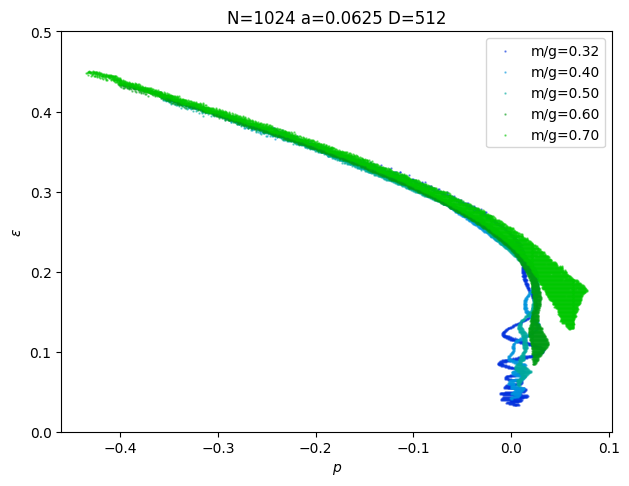

In [6]:

# FIG 4

plt.figure()

for j, (N, a, D, dt) in enumerate(NaDdt[:1]):
    for i, m in enumerate(ms):
        if i not in sel:
            continue

        tm, T00, midE = get_tsm(data[m, N, a, D, dt], 'T00')
        tm, T11, midp = get_tsm(data[m, N, a, D, dt], 'T11')
        tm, T01, midp = get_tsm(data[m, N, a, D, dt], 'T01')

        T00 = (T00[:, 1:] + T00[:, :-1])/2
        T11 = (T11[:, 1:] + T11[:, :-1])/2

        xmax = N * a / 2
        xs = np.linspace(-xmax, xmax, T00.shape[-1])

        x = np.zeros_like(T00)
        t = np.zeros_like(T00)
        x[:, :] = xs[np.newaxis, :]
        t[:, :] = tm[:, np.newaxis]

        tau2 = t ** 2 - x ** 2
        tau = np.zeros_like(tau2)
        tau[tau2>0] = np.sqrt(tau2[tau2>0])

        taumin = 2.5
        selfwd = (2 * np.abs(x) < t)

        # eps = 1/2*(T00 - T11 + np.sqrt((T00+T11)**2-4*T01**2))
        epsreg = 0.5 * (T00 - T11 + sqrtreg((T00 + T11) ** 2 - 4 * T01 ** 2))

        preg = T11 + epsreg - T00

        epsreg[tau<taumin] = 0
        preg[tau<taumin] = 0


        seltx = (tau>taumin) & selfwd & (t<tm[-1])

        epsreg[~seltx] = 0
        preg[~seltx] = 0


        pp = preg[seltx]
        ee = epsreg[seltx]
        # removing extra point by rounding
        multi = 1000
        ppee = np.column_stack([pp, ee])
        ppee = np.round(ppee * multi).astype(np.int64)
        ppee = np.unique(ppee, axis=0)
        ppee = ppee.astype(np.float64) / multi

        pp = ppee[:, 0]
        ee = ppee[:, 1]

        #plt.scatter(preg[seltx], epsreg[seltx], s=0.5, color=colors[i], label=f'{m/g=:.2f}', alpha=0.5)
        np.savetxt(f'p_vs_eps_{m=:.2f}.txt', np.column_stack([pp, ee]), header='p eps')
        plt.scatter(pp, ee, s=0.5, label=f'{m/g=:.2f}', alpha=0.5, color=colors[i])



plt.xlabel(r'$p$')
plt.ylabel(r'$\varepsilon$')

plt.ylim(0, 0.5)

plt.legend()
plt.tight_layout()
plt.title(f"{N=} {a=} {D=}")


plt.show()


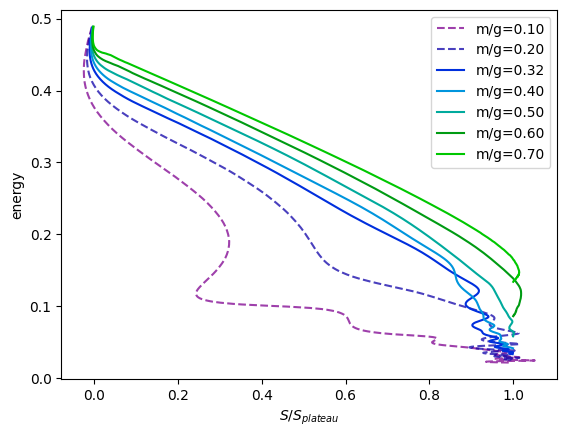

In [7]:
sel = [3, 4, 5, 6, 7]
# modified FIG 6
plt.figure()

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        if i==0 or i>7:
            continue

        ee = data[m, N, a, D, dt]["entropy_1"]
        eemid = ee[:, N // 2] - ee[0, N // 2]
        eerel = eemid/eemid[-1]

        tm, ee, midE = get_tsm(data[m, N, a, D, dt], 'T00')
        if i<3:
            plt.plot(eerel[8:-1], midE[8:-1], '--', color=colors[i], label=f'{m/g=:.2f}', alpha=0.75)
        else:
            plt.plot(eerel[8:-1], midE[8:-1], '-', color=colors[i], label=f'{m/g=:.2f}')
        np.savetxt(f'energy_vs_S_{m=:.2f}.txt', np.column_stack([eerel[8:-1], midE[8:-1]]))

plt.xlabel(r'$S/S_{plateau}$')
plt.ylabel(r'energy')
plt.legend()


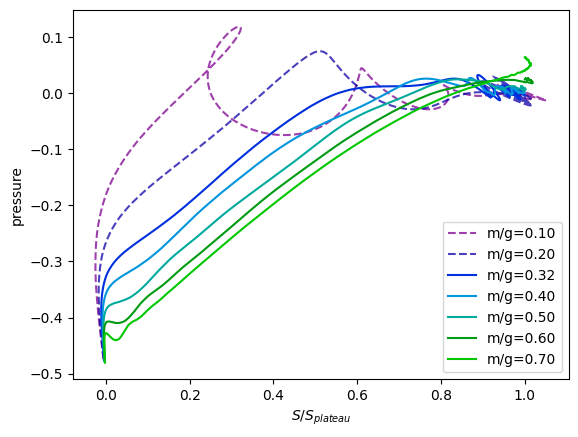

In [8]:
plt.figure()
#NaDdt =  [(512, 0.125, 1024, 1/16)]  # (512, 0.0625, 256, 1/16),
for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        if i==0 or i>7:
            continue

        ee = data[m, N, a, D, dt]["entropy_1"]
        eemid = ee[:, N // 2] - ee[0, N // 2]
        eerel = eemid/eemid[-1]

        tm, ee, midp = get_tsm(data[m, N, a, D, dt], 'T11')
        if i<3:
            plt.plot(eerel[8:-1], midp[8:-1], '--', color=colors[i], label=f'{m/g=:.2f}', alpha=0.75)
        else:
            plt.plot(eerel[8:-1], midp[8:-1], '-', color=colors[i], label=f'{m/g=:.2f}')
        np.savetxt(f'pressure_vs_S_{m=:.2f}.txt', np.column_stack([eerel[8:-1], midp[8:-1]]))

plt.xlabel(r'$S/S_{plateau}$')
plt.ylabel(r'pressure')
plt.legend()
# max electric field


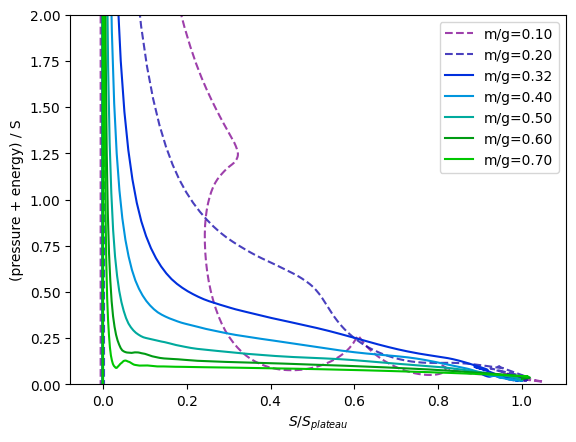

In [12]:
plt.figure()
#NaDdt =  [(512, 0.125, 1024, 1/16)]  # (512, 0.0625, 256, 1/16),
for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        if i==0 or i>7:
            continue

        ee = data[m, N, a, D, dt]["entropy_1"]
        eemid = ee[:, N // 2] - ee[0, N // 2]
        eerel = eemid/eemid[-1]

        tm, ee, mide = get_tsm(data[m, N, a, D, dt], 'T00')
        tm, ee, midp = get_tsm(data[m, N, a, D, dt], 'T11')
        if i<3:
            plt.plot(eerel[8:-1], (midp[8:-1] + mide[8:-1]) / eemid[8:-1], '--', color=colors[i], label=f'{m/g=:.2f}', alpha=0.75)
        else:
            plt.plot(eerel[8:-1], (midp[8:-1] + mide[8:-1]) / eemid[8:-1], '-', color=colors[i], label=f'{m/g=:.2f}')
        np.savetxt(f'pressure_vs_S_{m=:.2f}.txt', np.column_stack([eerel[8:-1], midp[8:-1]]))


plt.ylim([0, 2])
plt.xlabel(r'$S/S_{plateau}$')
plt.ylabel(r'(pressure + energy) / S')
plt.legend()
# max electric field

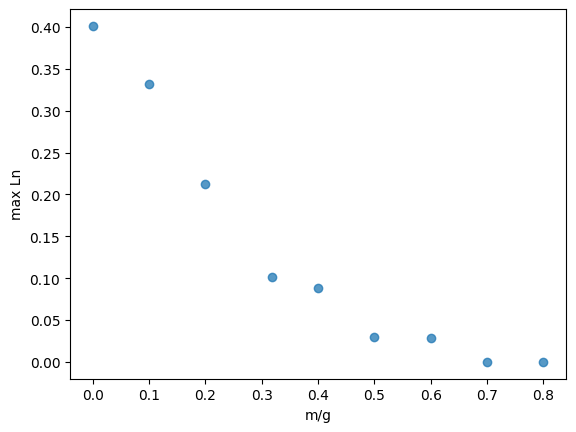

In [61]:
plt.figure()
maxLns = []

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        tm, ee, mid = get_tsm(data[m, N, a, D, dt], 'Ln')
        maxLns.append(np.amax(mid[:-2]))

plt.plot(ms[:-2], maxLns[:-2], 'o', alpha=0.75)

np.savetxt(f'max_Ln_{m=:.2f}.txt', np.column_stack([ms[:-2], maxLns[:-2]]))

plt.xlabel('m/g')
plt.ylabel('max Ln')
plt.show()